In [1]:
import os
import numpy as np
import scipy
import pandas as pd

import lmfit

from scipy.stats import norm, chi2 
from scipy.odr import ODR, Model, RealData

import matplotlib.pyplot as plt

In [10]:
#def damped_osc(t, A, omega_square, gamma, phase):
#    omega_damped = np.sqrt(omega_square - gamma**2)
#    return A*np.cos(omega_damped*t+phase)*np.exp(-gamma*t)

def damped_osc_odr(beta, t):
    A, omega_square, gamma, phase = beta
    omega_damped = np.sqrt(omega_square - gamma**2)
    return A*np.cos(omega_damped*t+phase)*np.exp(-gamma*t)    

In [11]:
def run_fit(x,  y, xerr=None, yerr=None, model= None, guess=None):
    
    # Wrap user-defined model into scipy.odr.Model
    model = Model(model)
    
    # Handle uncertainties: None -> zeros (ODR treats as no uncertainty)
    if xerr is None:
        xerr = np.zeros_like(x, dtype=float)
    if yerr is None:
        yerr = np.zeros_like(y, dtype=float)

    # Pack data with errors
    data = RealData(x, y, sx=xerr, sy=yerr)
    
    # Set up ODR
    odr = ODR(data, model, beta0=guess)
    
    # Run fit
    out = odr.run()
    
    # generalized chi²
    chi2 = np.sum((out.delta / xerr)**2 + (out.eps / yerr)**2)

    dof = len(x) - len(out.beta)  # degrees of freedom
    reduced_chi2 = chi2 / dof if dof > 0 else np.nan

    return {
        "beta": out.beta,
        "sd_beta": out.sd_beta,
        "cov_beta": out.cov_beta,
        "chi2": chi2,
        "reduced_chi2": reduced_chi2,
        "output": out
    }

In [24]:
def generate_damped_oscillator(t, A=1.0, gamma=0.1, omega2=2.0, phi=0.0, noise_std=0.05):
    clean = A * np.exp(-gamma * t) * np.cos(np.sqrt(omega2-gamma**2) * t + phi)
    noise = np.random.normal(0, noise_std, size=len(t))
    return clean + noise

# Example usage
np.random.seed(0)  # for reproducibility
t = np.linspace(0, 10, 200)
x = generate_damped_oscillator(t, A=1.0, gamma=0.2, omega2=2*np.pi, phi=0.3, noise_std=0.1)

In [37]:
dict = run_fit(t,  x, xerr=0.1, yerr=0.1, model=damped_osc_odr, guess=[1,3,0,1])

In [38]:
print(dict["output"].beta, dict["output"].sd_beta)

[1.03010644 6.25436325 0.19228027 0.30115341] [0.034253   0.05412268 0.00899481 0.04490757]


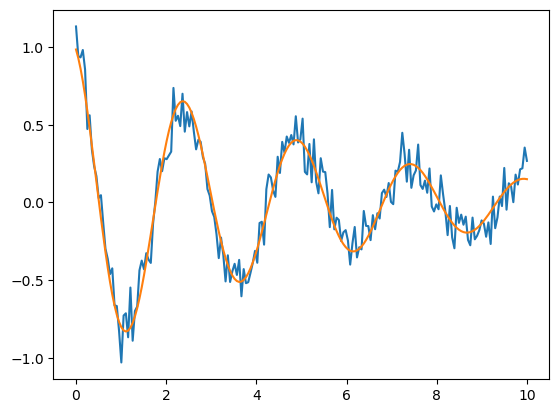

In [39]:
plt.plot(t, x)
plt.plot(t, damped_osc_odr(dict["output"].beta, t))

In [40]:
print(dict["reduced_chi2"])

0.7295489337359732
